In [1]:
import os
import re
import shutil
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)
import kagglehub

In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt


In [3]:

# Download latest version
path = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/stanford-dogs-dataset


In [4]:

# 1. Source (read‐only) and destination (writeable) roots
src_root = '/kaggle/input/stanford-dogs-dataset/images/Images'
dst_root = '/kaggle/working/Images_renamed'

os.makedirs(dst_root, exist_ok=True)

# 2. Iterate over each class folder in src_root
for old_name in os.listdir(src_root):
    old_path = os.path.join(src_root, old_name)
    if not os.path.isdir(old_path):
        continue

    # 3. Capture the part after the first dash
    m = re.match(r'^[^-]+-(.+)$', old_name)
    if not m:
        # if no dash, just keep the original name
        new_name = old_name
    else:
        new_name = m.group(1)

    dst_path = os.path.join(dst_root, new_name)

    # 4. Copy (and thus “rename”) in one step
    print(f'Copying "{old_name}" → "{new_name}"')
    shutil.copytree(old_path, dst_path)

print("All folders copied and renamed to:", dst_root)

Copying "n02091635-otterhound" → "otterhound"
Copying "n02102318-cocker_spaniel" → "cocker_spaniel"
Copying "n02101388-Brittany_spaniel" → "Brittany_spaniel"
Copying "n02088094-Afghan_hound" → "Afghan_hound"
Copying "n02085936-Maltese_dog" → "Maltese_dog"
Copying "n02104365-schipperke" → "schipperke"
Copying "n02100877-Irish_setter" → "Irish_setter"
Copying "n02086079-Pekinese" → "Pekinese"
Copying "n02099601-golden_retriever" → "golden_retriever"
Copying "n02100583-vizsla" → "vizsla"
Copying "n02102177-Welsh_springer_spaniel" → "Welsh_springer_spaniel"
Copying "n02093256-Staffordshire_bullterrier" → "Staffordshire_bullterrier"
Copying "n02106166-Border_collie" → "Border_collie"
Copying "n02093991-Irish_terrier" → "Irish_terrier"
Copying "n02109961-Eskimo_dog" → "Eskimo_dog"
Copying "n02110958-pug" → "pug"
Copying "n02105412-kelpie" → "kelpie"
Copying "n02094433-Yorkshire_terrier" → "Yorkshire_terrier"
Copying "n02097474-Tibetan_terrier" → "Tibetan_terrier"
Copying "n02089867-Walker_ho

In [5]:

# Set memory growth for GPU (prevents OOM errors)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

In [6]:
# ─── PARAMETERS ────────────────────────────────────────────────────────────────
SIZE = (299, 299)  # Default size for Xception
BATCH_SIZE = 32
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.7
EPOCHS = 10
SEED = 42

In [7]:
# ─── SETUP PATHS ─────────────────────────────────────────────────────────────────
# For Kaggle paths
orig_data_dir = "/kaggle/working/Images_renamed"
split_root = "/kaggle/working/Split_dataset"

train_dir = os.path.join(split_root, "train")
val_dir = os.path.join(split_root, "val")
test_dir = os.path.join(split_root, "test")

# Create directories
os.makedirs(split_root, exist_ok=True)
for d in (train_dir, val_dir, test_dir):
    os.makedirs(d, exist_ok=True)

In [8]:
# ─── SPLIT DATA ─────────────────────────────────────────────────────────────────
print("Splitting dataset...")

# Split percentages
train_frac = 0.70
val_frac = 0.15
test_frac = 0.15

for breed in os.listdir(orig_data_dir):
    breed_src = os.path.join(orig_data_dir, breed)
    if not os.path.isdir(breed_src):
        continue

    print(f"Processing: {breed}")

    # Get image files
    imgs = [f for f in os.listdir(breed_src) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

    # Split into train/val/test
    train_imgs, holdout = train_test_split(
        imgs, train_size=train_frac, random_state=SEED, shuffle=True
    )
    val_imgs, test_imgs = train_test_split(
        holdout, test_size=test_frac/(val_frac+test_frac),
        random_state=SEED, shuffle=True
    )

    # Copy files
    for subset, dest_dir in zip([train_imgs, val_imgs, test_imgs], [train_dir, val_dir, test_dir]):
        dest_breed_dir = os.path.join(dest_dir, breed)
        os.makedirs(dest_breed_dir, exist_ok=True)

        for img in subset:
            shutil.copy(os.path.join(breed_src, img), os.path.join(dest_breed_dir, img))

print("\nData split complete:")
print(" train:", sum(len(files) for r, d, files in os.walk(train_dir)))
print("  val:", sum(len(files) for r, d, files in os.walk(val_dir)))
print(" test:", sum(len(files) for r, d, files in os.walk(test_dir)))

Splitting dataset...
Processing: Norwegian_elkhound
Processing: Staffordshire_bullterrier
Processing: malamute
Processing: Brittany_spaniel
Processing: Irish_wolfhound
Processing: Norfolk_terrier
Processing: Great_Dane
Processing: kuvasz
Processing: dhole
Processing: soft-coated_wheaten_terrier
Processing: Shih-Tzu
Processing: basset
Processing: German_shepherd
Processing: silky_terrier
Processing: Doberman
Processing: Yorkshire_terrier
Processing: pug
Processing: Siberian_husky
Processing: Sussex_spaniel
Processing: chow
Processing: redbone
Processing: Newfoundland
Processing: Samoyed
Processing: Chihuahua
Processing: kelpie
Processing: cocker_spaniel
Processing: Gordon_setter
Processing: bloodhound
Processing: Tibetan_terrier
Processing: Eskimo_dog
Processing: EntleBucher
Processing: Kerry_blue_terrier
Processing: miniature_poodle
Processing: Bedlington_terrier
Processing: English_springer
Processing: Scottish_deerhound
Processing: Rottweiler
Processing: Walker_hound
Processing: Weim

In [9]:


# ─── CREATE DATA GENERATORS ──────────────────────────────────────────────────────
# Simple rescaling only - add augmentation later if needed
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)



train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_gen.num_classes
print(f"Number of classes: {num_classes}")

Found 14355 images belonging to 120 classes.
Found 3083 images belonging to 120 classes.
Found 3142 images belonging to 120 classes.
Number of classes: 120


In [10]:
import json

In [11]:
# 1) Load your class→index mapping
with open('/content/drive/MyDrive/ML_notes/Final_project/dog_models/class_names.json', 'r') as f:
    class_map = json.load(f)

# if class_map is { "breed_name": index, … }, invert it:
if all(isinstance(v, int) for v in class_map.values()):
    idx_to_class = {v: k for k, v in class_map.items()}
else:
    # if it’s already { "0": "breed_name", … } convert keys to int
    idx_to_class = {int(k): v for k, v in class_map.items()}

# 2) Load your trained model
model = load_model('/content/drive/MyDrive/ML_notes/Final_project/dog_models/best_model.h5', compile= False)

# 3) Preprocess the image
img_path = '/content/drive/MyDrive/ML_notes/Final_project/dog_data/images/Images/n02085620-Chihuahua/n02085620_10074.jpg'
img = image.load_img(img_path, target_size=(299, 299))
x   = image.img_to_array(img)
x  /= 255.0
x   = np.expand_dims(x, axis=0)   # shape → (1, 299, 299, 3)

# 4) Make prediction
preds      = model.predict(x)        # shape = (1, num_classes)
pred_index = np.argmax(preds[0])
pred_prob  = preds[0][pred_index]

# 5) Map back to breed name
pred_breed = idx_to_class[pred_index]

print(f"Predicted breed: {pred_breed}")
print(f"Confidence: {pred_prob*100:.1f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted breed: Chihuahua
Confidence: 99.1%


In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


Found 3142 images belonging to 120 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 40s 270ms/step
Overall accuracy: 0.9122


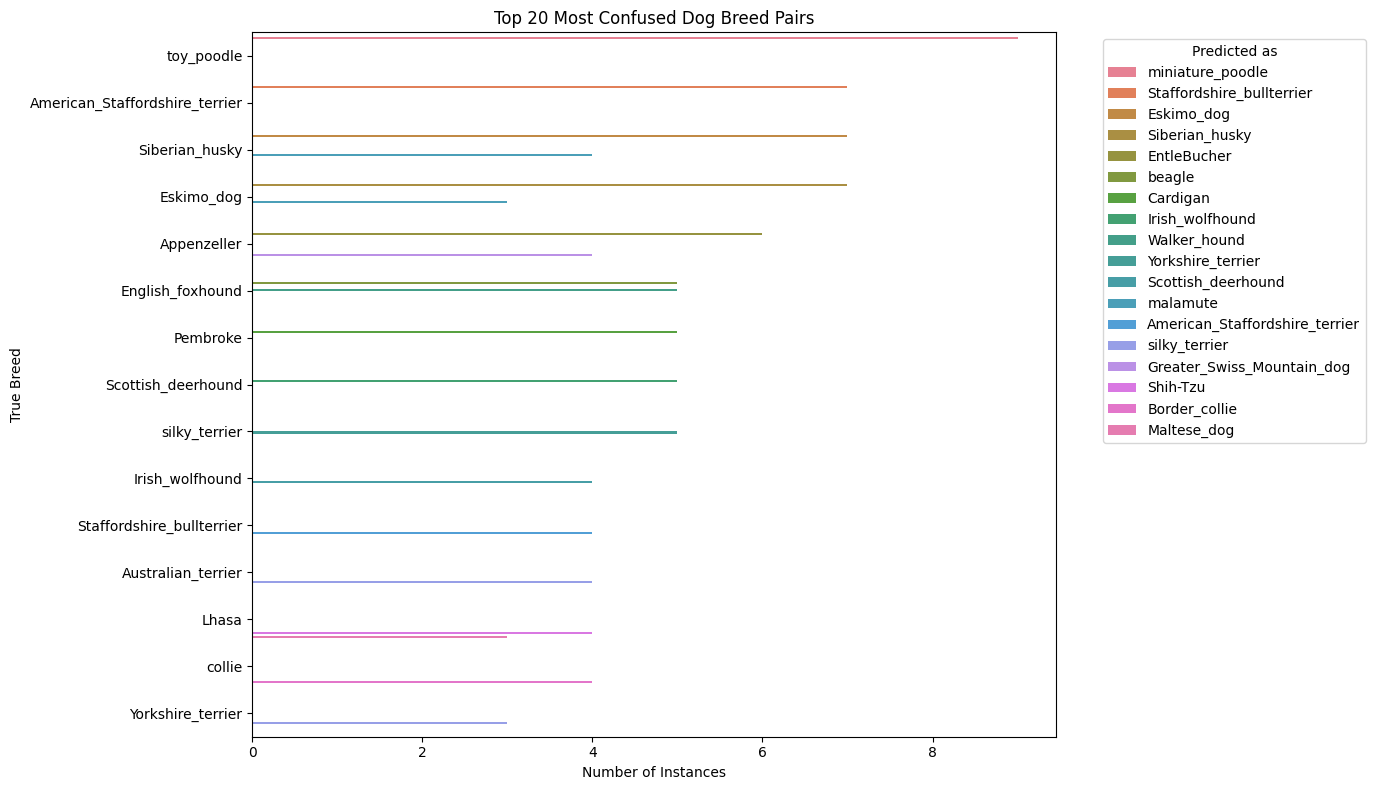

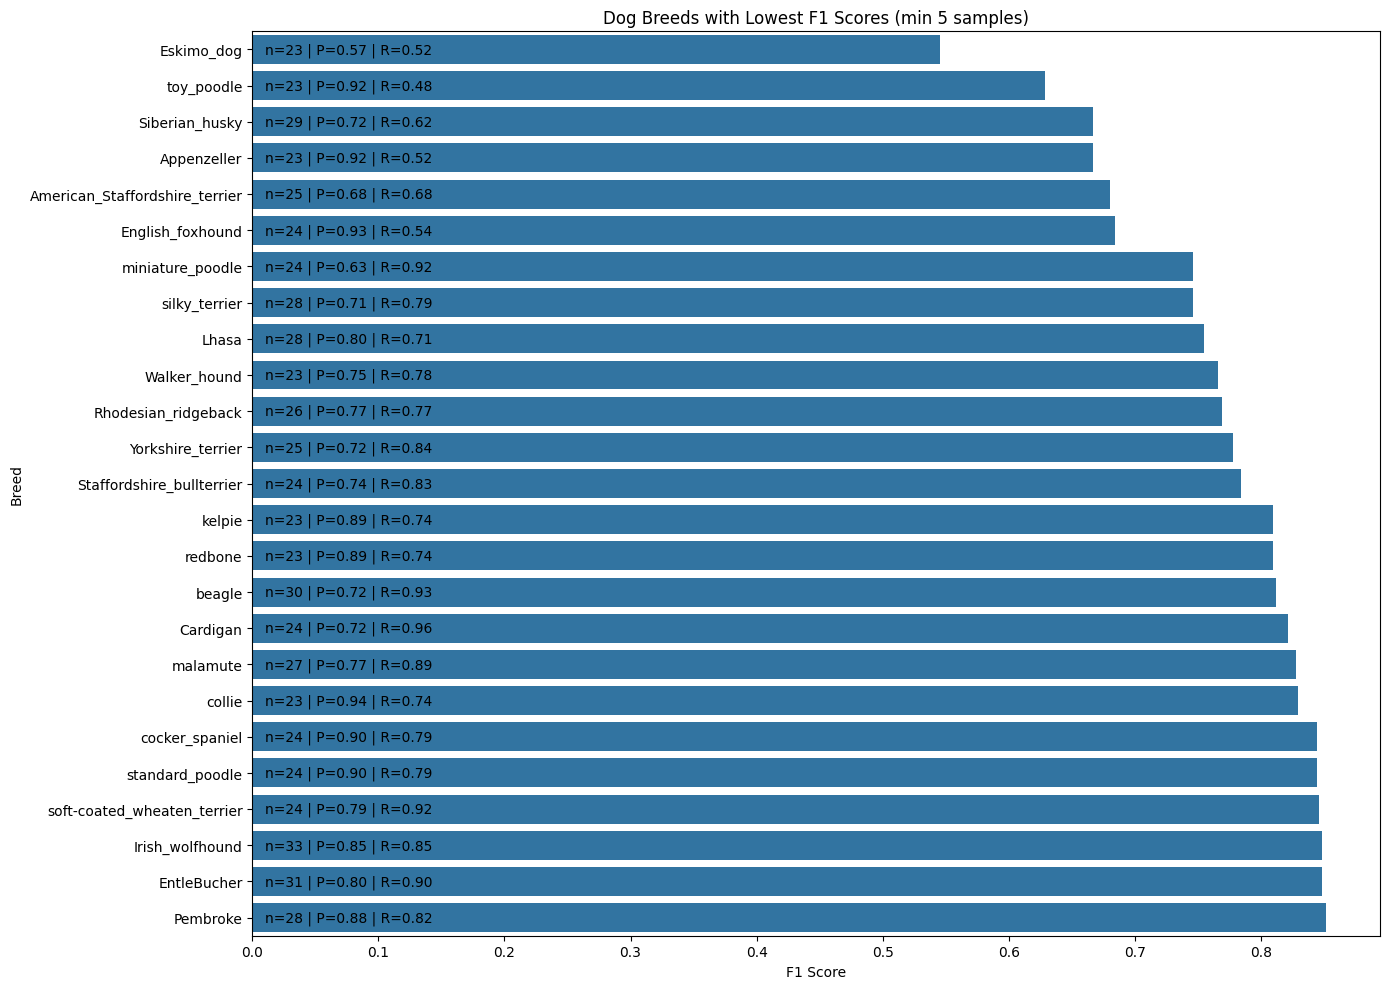

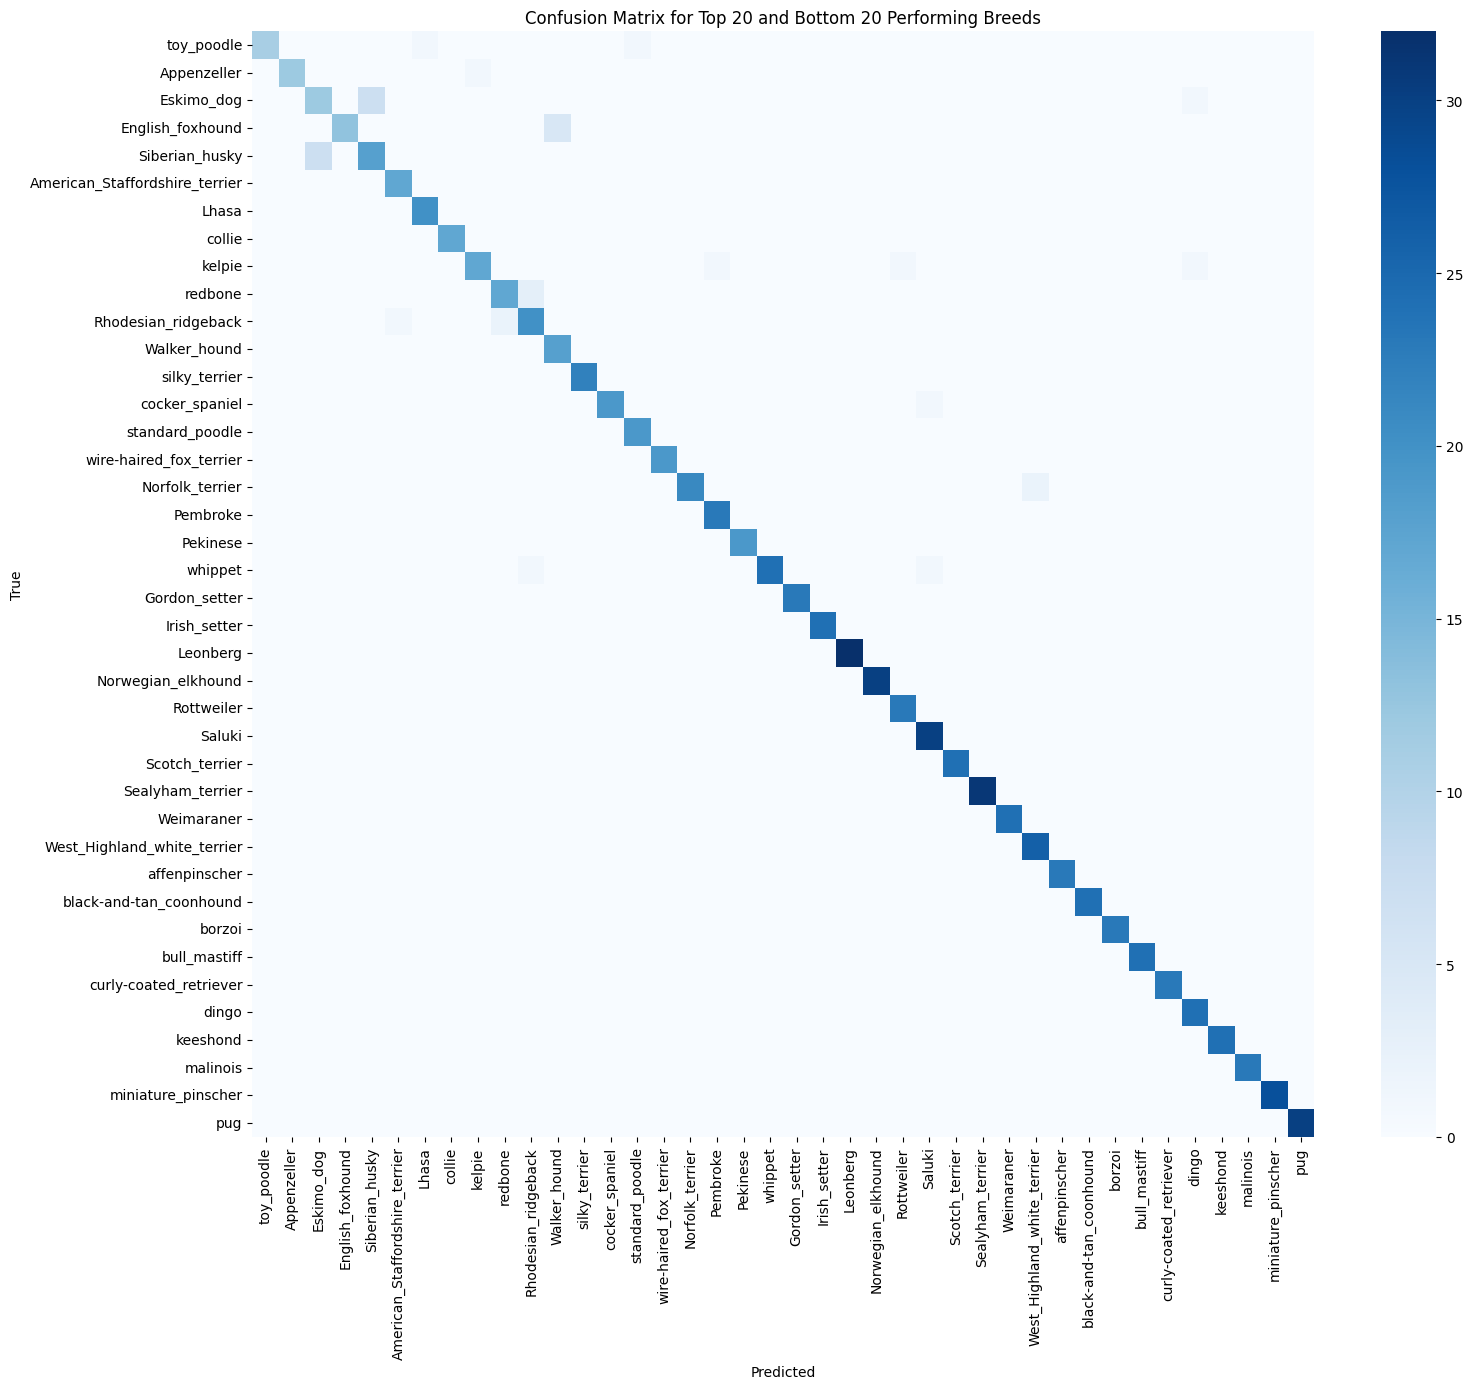

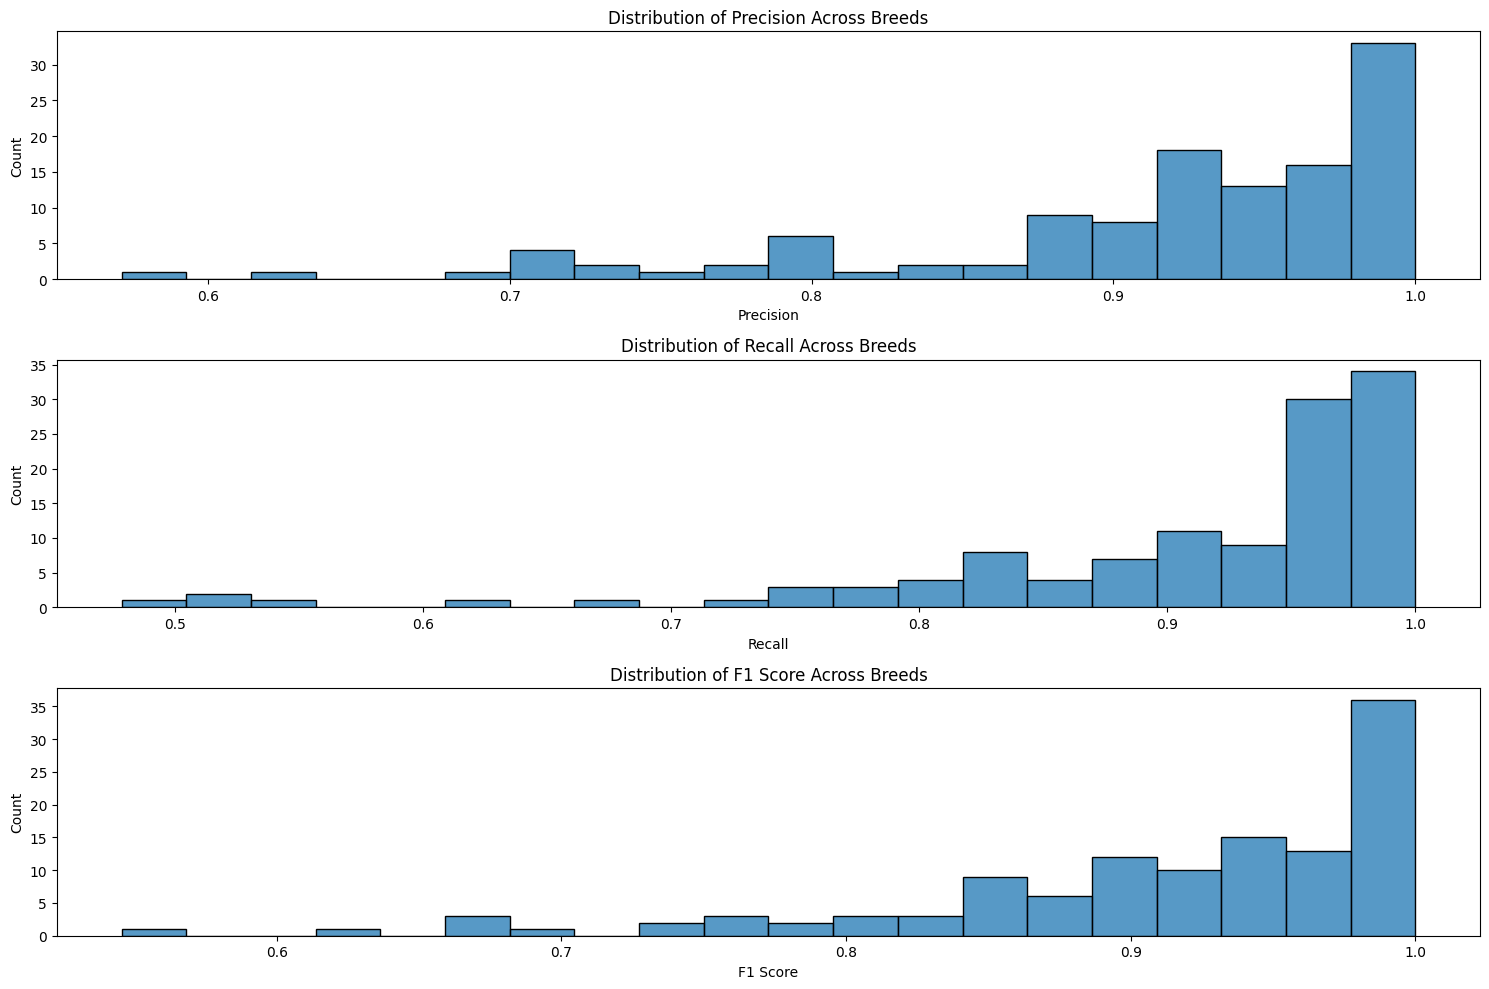

In [13]:
# 1) Re-create a generator with shuffle=False
test_eval_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False   # important!
)

# 2) Get true labels
y_true = test_eval_gen.classes                 # array of ints, one per image

# 3) Predict
y_prob = model.predict(
    test_eval_gen,
    steps = np.ceil(test_eval_gen.samples / BATCH_SIZE).astype(int)
)
y_pred = np.argmax(y_prob, axis=1)

# 4) Get class names
labels = list(test_eval_gen.class_indices.keys())  # list of class names in index order

# 5) Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print(f"Overall accuracy: {accuracy:.4f}")

# 6) Create confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

# 7) Calculate per-class metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate precision, recall, and f1-score for each class
class_metrics = []
for i in range(len(labels)):
    true_positives = cm[i, i]
    false_positives = np.sum(cm[:, i]) - true_positives
    false_negatives = np.sum(cm[i, :]) - true_positives

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    sample_count = np.sum(cm[i, :])

    class_metrics.append({
        'Breed': labels[i],
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Samples': sample_count
    })

metrics_df = pd.DataFrame(class_metrics)

# 8) Visualization 1: Top 20 most confused pairs
confusion_pairs = []
for i in range(len(labels)):
    for j in range(len(labels)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append({
                'True': labels[i],
                'Predicted': labels[j],
                'Count': cm[i, j]
            })

confusion_df = pd.DataFrame(confusion_pairs)
confusion_df = confusion_df.sort_values('Count', ascending=False)

plt.figure(figsize=(14, 8))
top_confused = confusion_df.head(20)
ax = sns.barplot(x='Count', y='True', hue='Predicted', data=top_confused)
plt.title('Top 20 Most Confused Dog Breed Pairs')
plt.xlabel('Number of Instances')
plt.ylabel('True Breed')
plt.legend(title='Predicted as', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('top_confused_pairs.png')
plt.show()

# 9) Visualization 2: Worst performing breeds (lowest F1 score)
# Filter out breeds with too few samples
min_samples = 5
filtered_metrics = metrics_df[metrics_df['Samples'] >= min_samples].sort_values('F1')

plt.figure(figsize=(14, 10))
bottom_f1 = filtered_metrics.head(25)
ax = sns.barplot(x='F1', y='Breed', data=bottom_f1)
plt.title('Dog Breeds with Lowest F1 Scores (min 5 samples)')
plt.xlabel('F1 Score')
plt.ylabel('Breed')

# Add sample count and precision/recall to the labels
for i, row in enumerate(bottom_f1.itertuples()):
    ax.text(0.01, i, f"n={row.Samples} | P={row.Precision:.2f} | R={row.Recall:.2f}", va='center')

plt.tight_layout()
plt.savefig('worst_performing_breeds.png')
plt.show()

# 10) Visualization 3: Heat map of the diagonal (correct classifications)
# Create a diagonal matrix
diag_matrix = np.diag(np.diag(cm))
diag_df = pd.DataFrame(diag_matrix, columns=labels, index=labels)

# Sort breeds by accuracy
breed_accuracy = []
for i in range(len(labels)):
    total = np.sum(cm[i, :])
    correct = cm[i, i]
    acc = correct / total if total > 0 else 0
    breed_accuracy.append((labels[i], acc, total))

# Sort by accuracy
breed_accuracy.sort(key=lambda x: x[1])
sorted_labels = [x[0] for x in breed_accuracy]

# Take top and bottom 20 breeds for comparison
top_20 = sorted_labels[-20:]
bottom_20 = sorted_labels[:20]
selected_breeds = bottom_20 + top_20

# Extract the relevant part of the confusion matrix
selected_indices = [labels.index(breed) for breed in selected_breeds]
selected_cm = cm[selected_indices, :][:, selected_indices]

# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(selected_cm, xticklabels=selected_breeds, yticklabels=selected_breeds,
           cmap="Blues", annot=False)
plt.title('Confusion Matrix for Top 20 and Bottom 20 Performing Breeds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('selected_confusion_matrix.png')
plt.show()

# 11) Visualization 4: Distribution of metrics across all breeds
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
sns.histplot(metrics_df['Precision'], bins=20)
plt.title('Distribution of Precision Across Breeds')
plt.xlabel('Precision')
plt.ylabel('Count')

plt.subplot(3, 1, 2)
sns.histplot(metrics_df['Recall'], bins=20)
plt.title('Distribution of Recall Across Breeds')
plt.xlabel('Recall')
plt.ylabel('Count')

plt.subplot(3, 1, 3)
sns.histplot(metrics_df['F1'], bins=20)
plt.title('Distribution of F1 Score Across Breeds')
plt.xlabel('F1 Score')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('metric_distributions.png')
plt.show()

Found 3083 images belonging to 120 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 28s 282ms/step
Overall accuracy: 0.9254


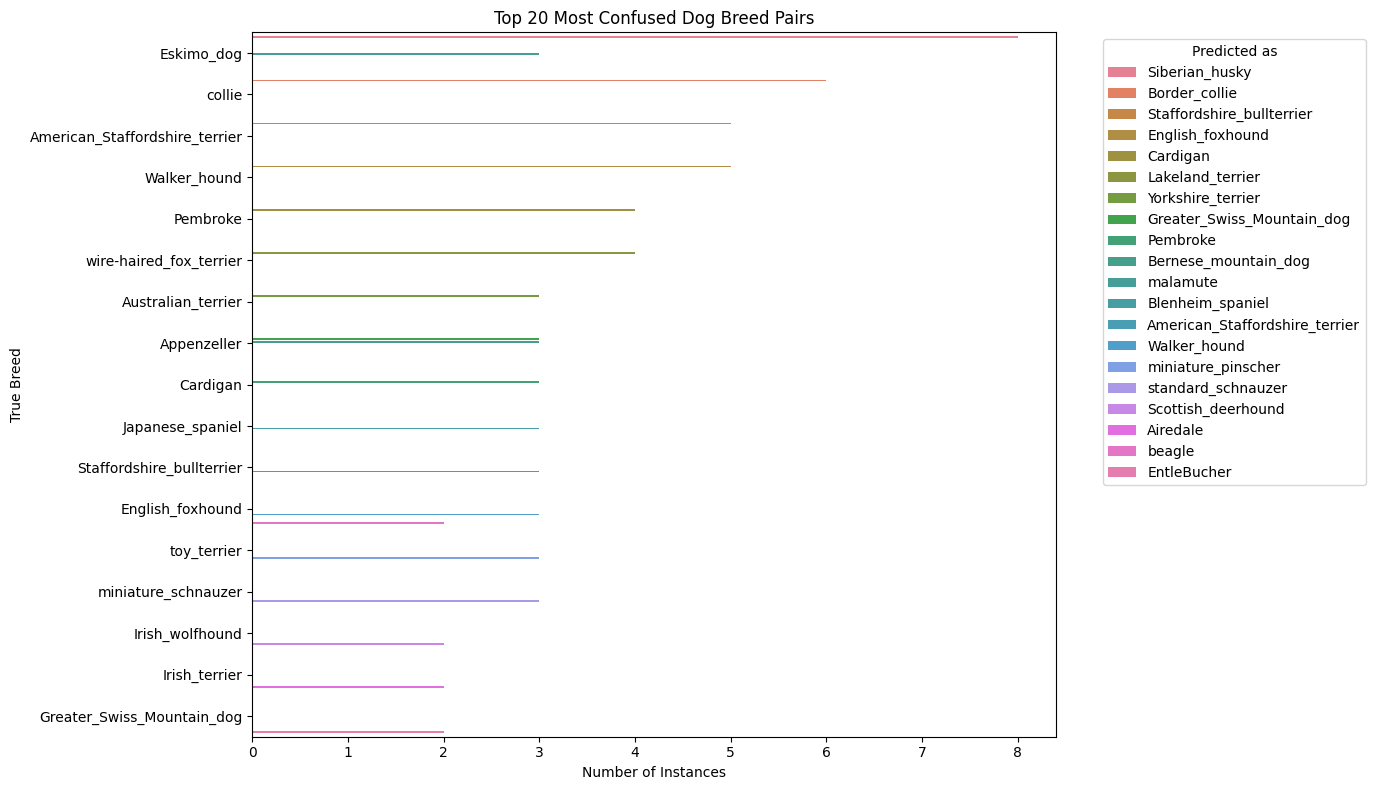

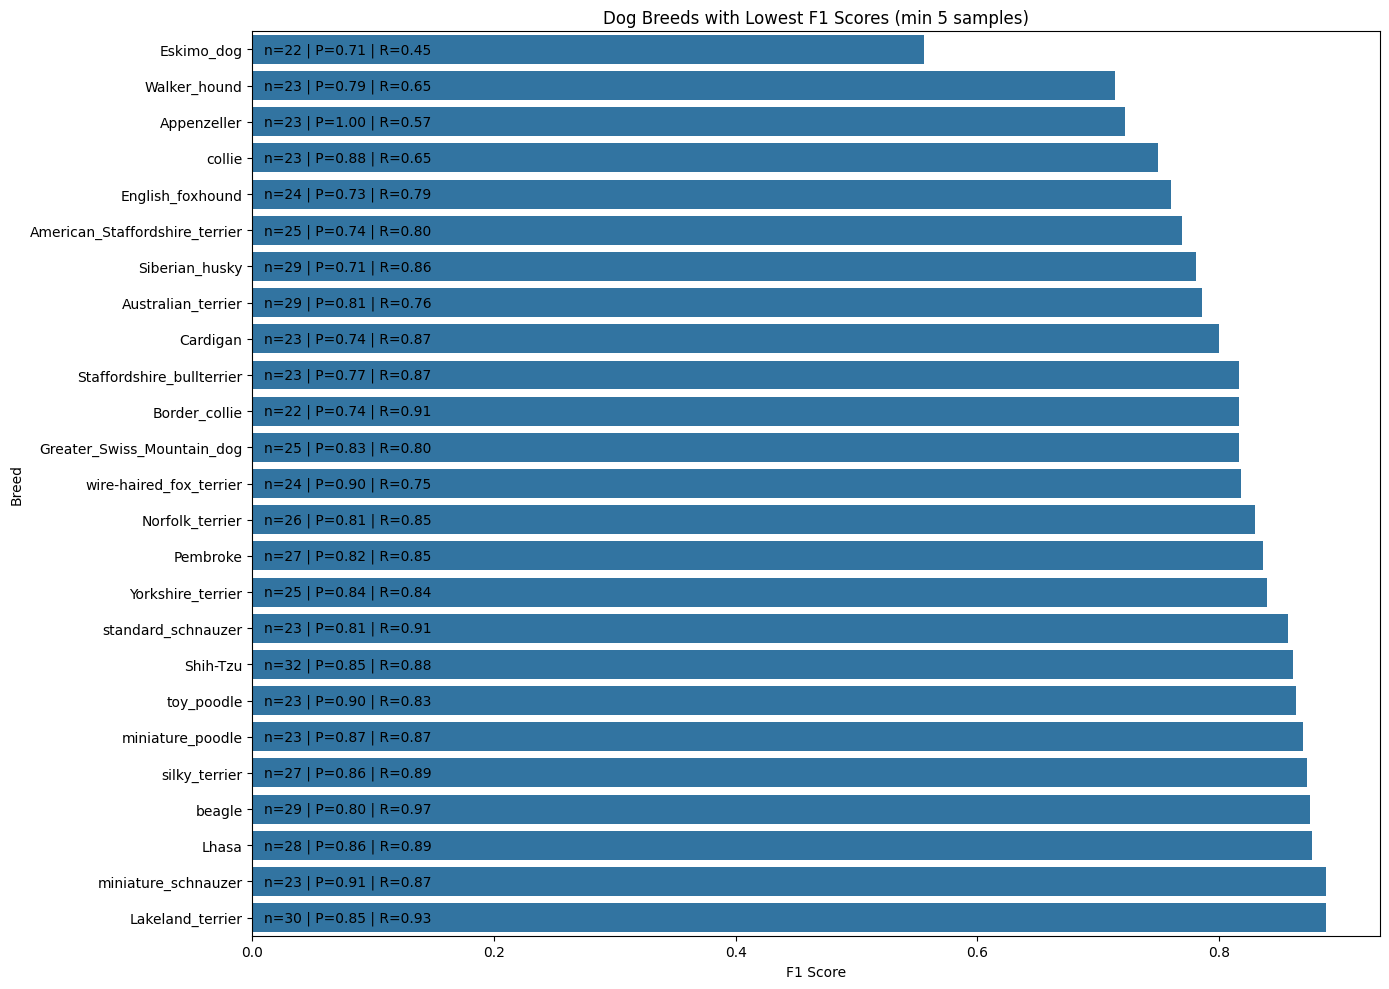

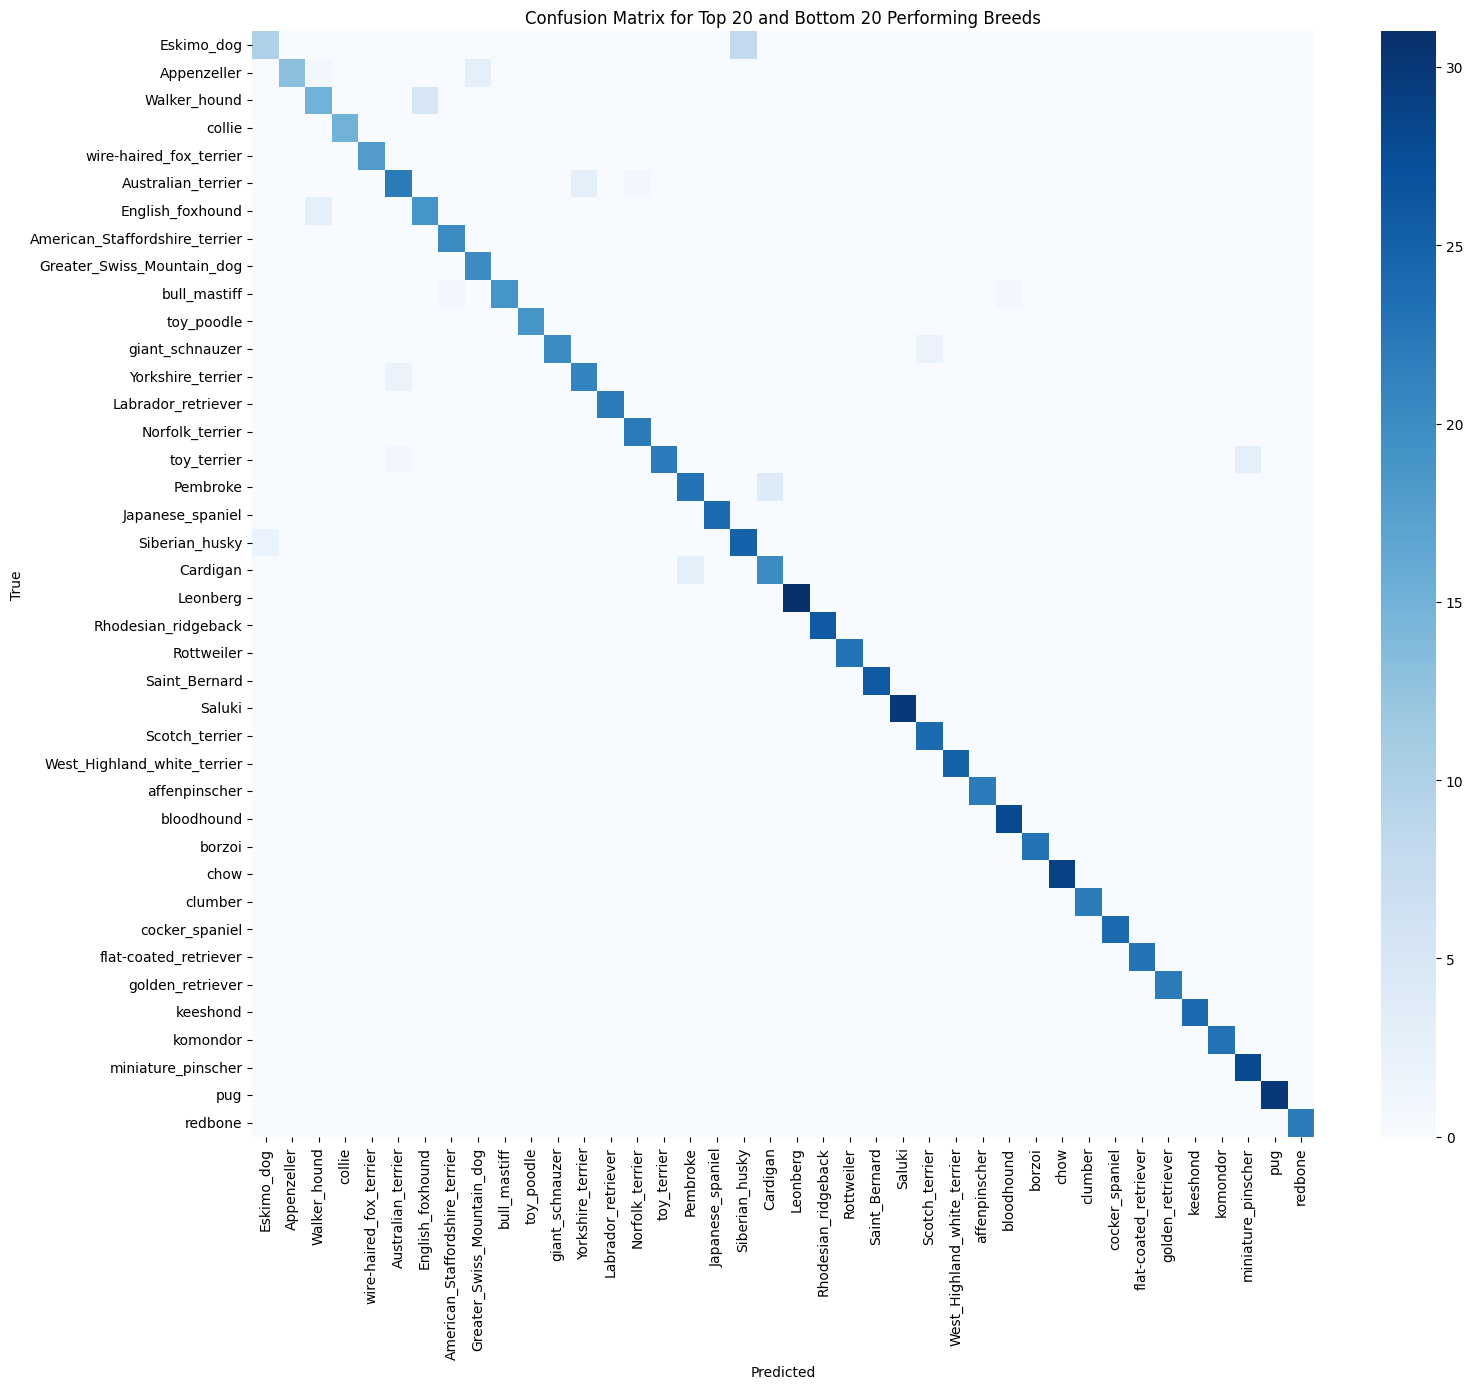

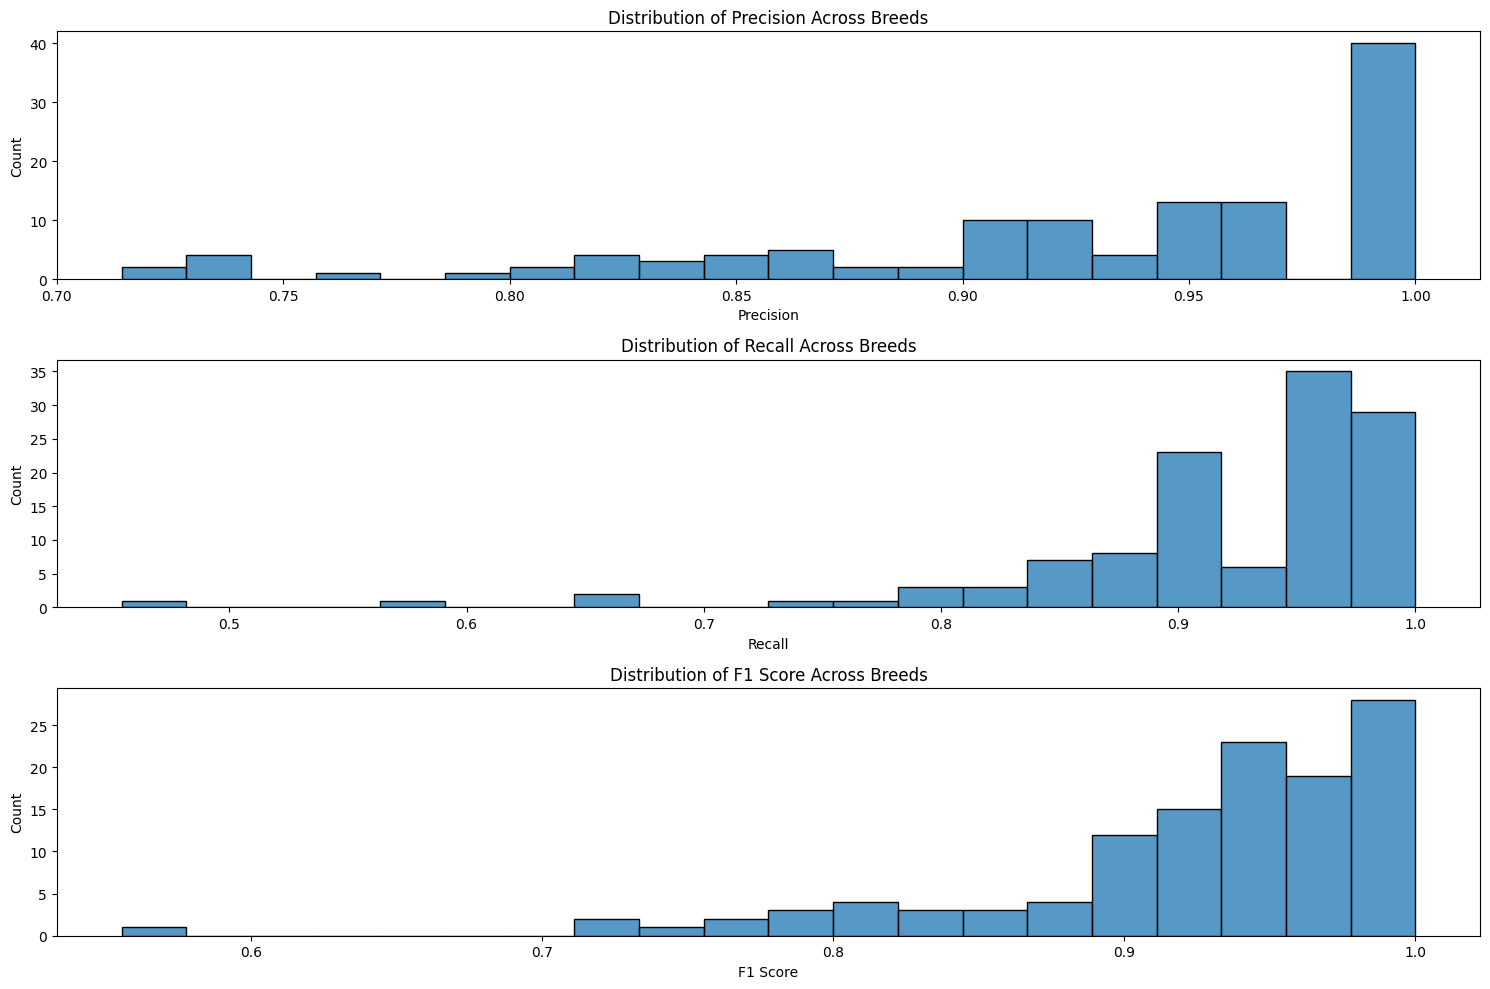

In [17]:
# 1) Re-create a generator with shuffle=False
val_eval_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False   # important!
)

# 2) Get true labels
y_true = val_eval_gen.classes                 # array of ints, one per image

# 3) Predict
y_prob = model.predict(
    val_eval_gen,
    steps = np.ceil(val_eval_gen.samples / BATCH_SIZE).astype(int)
)
y_pred = np.argmax(y_prob, axis=1)

# 4) Get class names
labels = list(val_eval_gen.class_indices.keys())  # list of class names in index order

# 5) Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print(f"Overall accuracy: {accuracy:.4f}")

# 6) Create confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

# 7) Calculate per-class metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate precision, recall, and f1-score for each class
class_metrics = []
for i in range(len(labels)):
    true_positives = cm[i, i]
    false_positives = np.sum(cm[:, i]) - true_positives
    false_negatives = np.sum(cm[i, :]) - true_positives

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    sample_count = np.sum(cm[i, :])

    class_metrics.append({
        'Breed': labels[i],
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Samples': sample_count
    })

metrics_df = pd.DataFrame(class_metrics)

# 8) Visualization 1: Top 20 most confused pairs
confusion_pairs = []
for i in range(len(labels)):
    for j in range(len(labels)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append({
                'True': labels[i],
                'Predicted': labels[j],
                'Count': cm[i, j]
            })

confusion_df = pd.DataFrame(confusion_pairs)
confusion_df = confusion_df.sort_values('Count', ascending=False)

plt.figure(figsize=(14, 8))
top_confused = confusion_df.head(20)
ax = sns.barplot(x='Count', y='True', hue='Predicted', data=top_confused)
plt.title('Top 20 Most Confused Dog Breed Pairs')
plt.xlabel('Number of Instances')
plt.ylabel('True Breed')
plt.legend(title='Predicted as', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('top_confused_pairs.png')
plt.show()

# 9) Visualization 2: Worst performing breeds (lowest F1 score)
# Filter out breeds with too few samples
min_samples = 5
filtered_metrics = metrics_df[metrics_df['Samples'] >= min_samples].sort_values('F1')

plt.figure(figsize=(14, 10))
bottom_f1 = filtered_metrics.head(25)
ax = sns.barplot(x='F1', y='Breed', data=bottom_f1)
plt.title('Dog Breeds with Lowest F1 Scores (min 5 samples)')
plt.xlabel('F1 Score')
plt.ylabel('Breed')

# Add sample count and precision/recall to the labels
for i, row in enumerate(bottom_f1.itertuples()):
    ax.text(0.01, i, f"n={row.Samples} | P={row.Precision:.2f} | R={row.Recall:.2f}", va='center')

plt.tight_layout()
plt.savefig('worst_performing_breeds.png')
plt.show()

# 10) Visualization 3: Heat map of the diagonal (correct classifications)
# Create a diagonal matrix
diag_matrix = np.diag(np.diag(cm))
diag_df = pd.DataFrame(diag_matrix, columns=labels, index=labels)

# Sort breeds by accuracy
breed_accuracy = []
for i in range(len(labels)):
    total = np.sum(cm[i, :])
    correct = cm[i, i]
    acc = correct / total if total > 0 else 0
    breed_accuracy.append((labels[i], acc, total))

# Sort by accuracy
breed_accuracy.sort(key=lambda x: x[1])
sorted_labels = [x[0] for x in breed_accuracy]

# Take top and bottom 20 breeds for comparison
top_20 = sorted_labels[-20:]
bottom_20 = sorted_labels[:20]
selected_breeds = bottom_20 + top_20

# Extract the relevant part of the confusion matrix
selected_indices = [labels.index(breed) for breed in selected_breeds]
selected_cm = cm[selected_indices, :][:, selected_indices]

# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(selected_cm, xticklabels=selected_breeds, yticklabels=selected_breeds,
           cmap="Blues", annot=False)
plt.title('Confusion Matrix for Top 20 and Bottom 20 Performing Breeds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('selected_confusion_matrix.png')
plt.show()

# 11) Visualization 4: Distribution of metrics across all breeds
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
sns.histplot(metrics_df['Precision'], bins=20)
plt.title('Distribution of Precision Across Breeds')
plt.xlabel('Precision')
plt.ylabel('Count')

plt.subplot(3, 1, 2)
sns.histplot(metrics_df['Recall'], bins=20)
plt.title('Distribution of Recall Across Breeds')
plt.xlabel('Recall')
plt.ylabel('Count')

plt.subplot(3, 1, 3)
sns.histplot(metrics_df['F1'], bins=20)
plt.title('Distribution of F1 Score Across Breeds')
plt.xlabel('F1 Score')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('metric_distributions.png')
plt.show()

In [14]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

In [15]:
# ─── 1) Set up a non-shuffling test generator ────────────────────────────────
test_eval_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,       # deterministic order
    seed=42
)

# ─── 2) Gather true labels and class names ──────────────────────────────────
y_true = test_eval_gen.classes
labels = list(test_eval_gen.class_indices.keys())

# ─── 3) Predict ──────────────────────────────────────────────────────────────
steps = int(np.ceil(test_eval_gen.samples / BATCH_SIZE))
y_prob = model.predict(test_eval_gen, steps=steps)
y_pred = np.argmax(y_prob, axis=1)

# ─── 4) Overall accuracy ────────────────────────────────────────────────────
acc = accuracy_score(y_true, y_pred)
print(f"\nOverall accuracy: {acc:.4f}\n")

# ─── 5) Per‐breed precision / recall / F1 via sklearn report ───────────────
print("Per-breed Precision / Recall / F1:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=labels,
    digits=4,
    zero_division=0
))

# ─── 6) Per‐breed “accuracy” (TP / total samples of that breed) ────────────
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
per_class_acc = cm.diagonal() / cm.sum(axis=1)

print("Per-breed Accuracy (correct predictions ÷ total samples):\n")
for breed, acc in zip(labels, per_class_acc):
    print(f"{breed:25s}: {acc:.4f}")

# Optional: collect into a DataFrame for easy export
df = pd.DataFrame({
    'Breed': labels,
    'Precision': precision_score(y_true, y_pred, average=None, zero_division=0),
    'Recall':    recall_score(y_true, y_pred, average=None, zero_division=0),
    'F1-score':  f1_score(y_true, y_pred, average=None, zero_division=0),
    'Accuracy':  per_class_acc,
    'Support':   cm.sum(axis=1)
})
print("\nSummary table:")
print(df.to_string(index=False))

Found 3142 images belonging to 120 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step

Overall accuracy: 0.9122

Per-breed Precision / Recall / F1:

                                precision    recall  f1-score   support

                  Afghan_hound     0.9730    1.0000    0.9863        36
           African_hunting_dog     1.0000    1.0000    1.0000        26
                      Airedale     0.9118    1.0000    0.9538        31
American_Staffordshire_terrier     0.6800    0.6800    0.6800        25
                   Appenzeller     0.9231    0.5217    0.6667        23
            Australian_terrier     0.9615    0.8333    0.8929        30
            Bedlington_terrier     1.0000    1.0000    1.0000        28
          Bernese_mountain_dog     0.9412    0.9697    0.9552        33
              Blenheim_spaniel     0.9355    1.0000    0.9667        29
                 Border_collie     0.7931    1.0000    0.8846        23
                Border_terrier     1.0000    0.9615    0.9804        26
                   Boston_bull

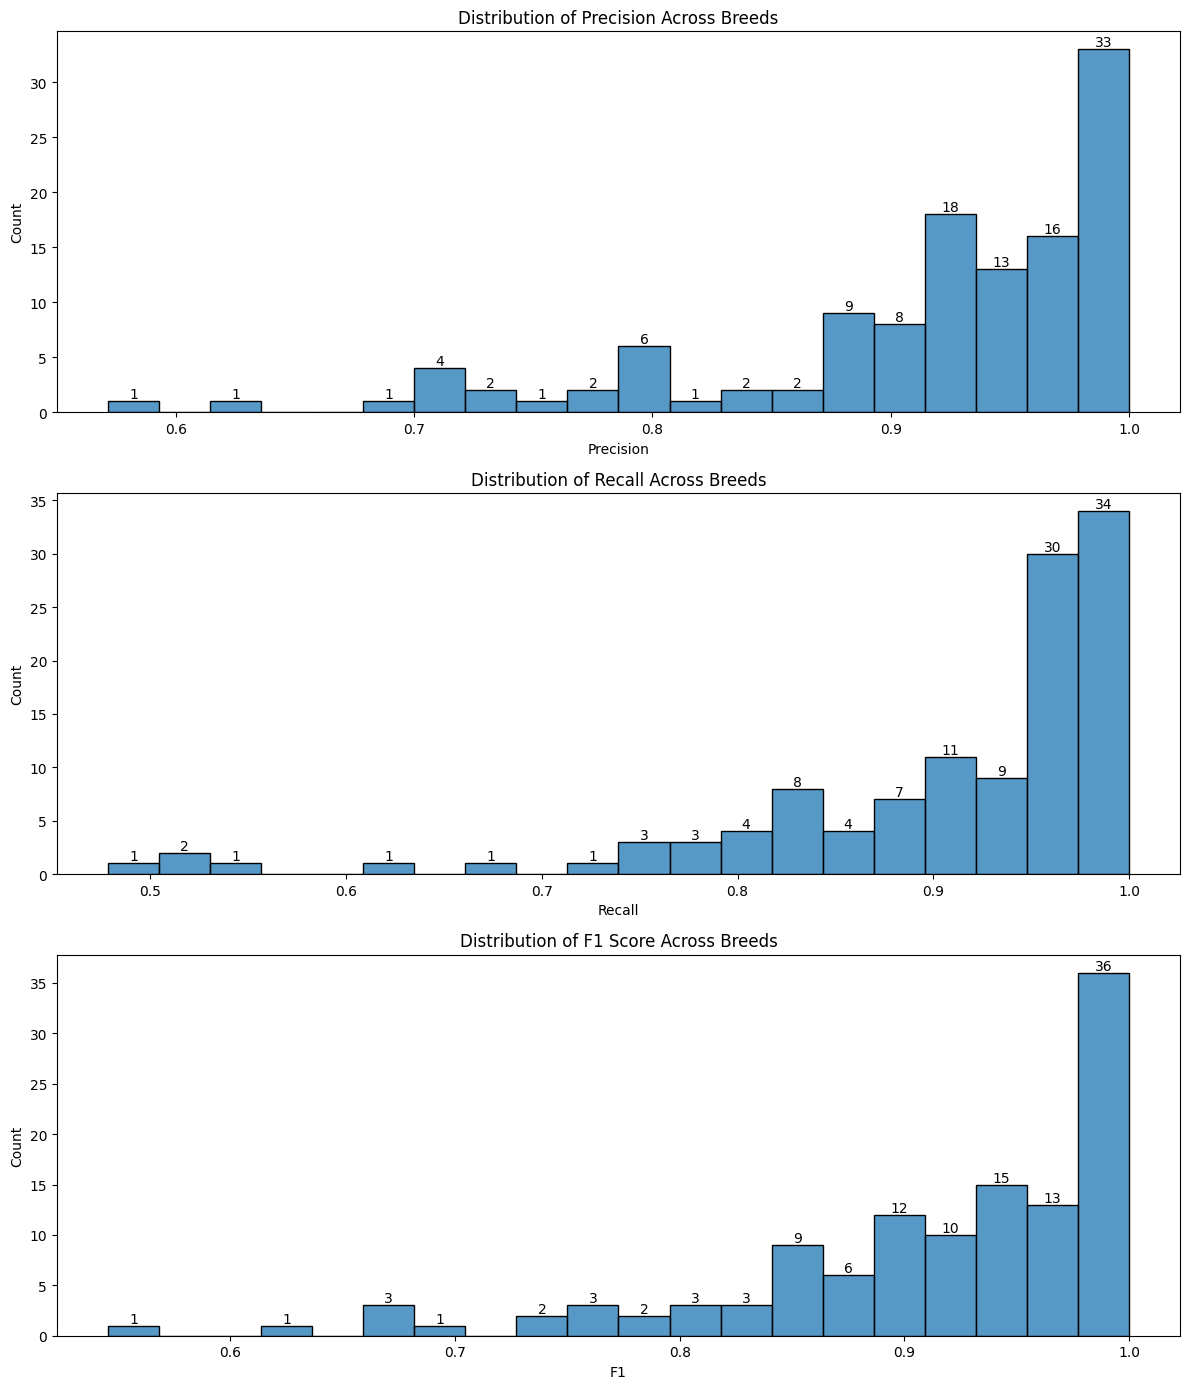

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# assume you already have `metrics_df` with columns 'Precision', 'Recall', 'F1'
metrics = ['Precision', 'Recall', 'F1']
titles = [
    'Distribution of Precision Across Breeds',
    'Distribution of Recall Across Breeds',
    'Distribution of F1 Score Across Breeds'
]

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 14))

for ax, metric, title in zip(axes, metrics, titles):
    # draw histogram
    sns.histplot(metrics_df[metric], bins=20, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(metric)
    ax.set_ylabel('Count')

    # annotate each bar
    for patch in ax.patches:
        height = patch.get_height()
        if height > 0:  # skip zero‐height bars
            ax.text(
                patch.get_x() + patch.get_width() / 2,  # x‐position: center of bar
                height,                                 # y‐position: top of bar
                int(height),                            # label = count
                ha='center',
                va='bottom'
            )

plt.tight_layout()
plt.show()


In [ ]:
# 1) First, perform your evaluation as before
val_eval_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False   # important!
)

# Get true labels
y_true = val_eval_gen.classes
class_indices = val_eval_gen.class_indices
labels = list(class_indices.keys())

# Predict
y_prob = model.predict(
    val_eval_gen,
    steps = np.ceil(val_eval_gen.samples / BATCH_SIZE).astype(int)
)
y_pred = np.argmax(y_prob, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

# 2) Save the basic results to CSV files
import pandas as pd
import json
import pickle
import os

# Create a directory for saving evaluation results
results_dir = '/content/drive/MyDrive/ML_notes/Final_project/dog_models'
os.makedirs(results_dir, exist_ok=True)

# Save class indices mapping
with open(f'{results_dir}/class_indices.json', 'w') as f:
    json.dump(class_indices, f)

# Save true and predicted labels
results_df = pd.DataFrame({
    'true_label': [labels[i] for i in y_true],
    'true_label_index': y_true,
    'predicted_label': [labels[i] for i in y_pred],
    'predicted_label_index': y_pred,
})
results_df.to_csv(f'{results_dir}/prediction_results.csv', index=False)

# Save probabilities (useful for ROC curves, etc.)
prob_df = pd.DataFrame(y_prob, columns=[labels[i] for i in range(len(labels))])
prob_df.to_csv(f'{results_dir}/prediction_probabilities.csv', index=False)

# Save confusion matrix
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df.to_csv(f'{results_dir}/confusion_matrix.csv')

# 3) Save detailed per-class metrics
# Calculate precision, recall, and f1-score for each class
class_metrics = []
for i in range(len(labels)):
    true_positives = cm[i, i]
    false_positives = np.sum(cm[:, i]) - true_positives
    false_negatives = np.sum(cm[i, :]) - true_positives

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    sample_count = np.sum(cm[i, :])

    class_metrics.append({
        'Breed': labels[i],
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Samples': sample_count,
        'True_Positives': true_positives,
        'False_Positives': false_positives,
        'False_Negatives': false_negatives
    })

metrics_df = pd.DataFrame(class_metrics)
metrics_df.to_csv(f'{results_dir}/class_metrics.csv', index=False)

# 4) Save most confused pairs
confusion_pairs = []
for i in range(len(labels)):
    for j in range(len(labels)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append({
                'True': labels[i],
                'Predicted': labels[j],
                'Count': cm[i, j]
            })

confusion_df = pd.DataFrame(confusion_pairs)
confusion_df = confusion_df.sort_values('Count', ascending=False)
confusion_df.to_csv(f'{results_dir}/confusion_pairs.csv', index=False)

# 5) Save raw data in pickle format for more complex analysis later
# This preserves all data structures including numpy arrays
evaluation_data = {
    'y_true': y_true,
    'y_pred': y_pred,
    'y_prob': y_prob,
    'labels': labels,
    'class_indices': class_indices,
    'confusion_matrix': cm,
    'class_metrics': class_metrics
}

with open(f'{results_dir}/evaluation_data.pkl', 'wb') as f:
    pickle.dump(evaluation_data, f)

print(f"Evaluation results saved to '{results_dir}' directory")
print(f"Files saved:")
print(f"  - class_indices.json: Mapping between class indices and breed names")
print(f"  - prediction_results.csv: True and predicted labels for each sample")
print(f"  - prediction_probabilities.csv: Probability scores for each class")
print(f"  - confusion_matrix.csv: Full confusion matrix")
print(f"  - class_metrics.csv: Precision, recall, F1, etc. for each breed")
print(f"  - confusion_pairs.csv: Most confused breed pairs")
print(f"  - evaluation_data.pkl: Complete evaluation data in Python pickle format")

Found 3083 images belonging to 120 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step
Evaluation results saved to '/content/drive/MyDrive/ML_notes/Final_project/dog_models' directory
Files saved:
  - class_indices.json: Mapping between class indices and breed names
  - prediction_results.csv: True and predicted labels for each sample
  - prediction_probabilities.csv: Probability scores for each class
  - confusion_matrix.csv: Full confusion matrix
  - class_metrics.csv: Precision, recall, F1, etc. for each breed
  - confusion_pairs.csv: Most confused breed pairs
  - evaluation_data.pkl: Complete evaluation data in Python pickle format


In [ ]:
import os
import numpy as np
import pandas as pd
import json
import pickle
from sklearn.metrics import confusion_matrix

# Create a directory for saving evaluation results
# Create a directory for saving evaluation results
results_dir = '/content/drive/MyDrive/ML_notes/Final_project/dog_models/results'
os.makedirs(results_dir, exist_ok=True)


# Define a function to evaluate and save results for a dataset
def evaluate_and_save(dataset_name, directory, batch_size, model, size):
    print(f"\nEvaluating model on {dataset_name} set...")

    # Create generator for evaluation
    eval_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory,
        target_size=size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Get true labels and class indices
    y_true = eval_gen.classes
    class_indices = eval_gen.class_indices
    labels = list(class_indices.keys())

    # Get predictions
    y_prob = model.predict(
        eval_gen,
        steps=np.ceil(eval_gen.samples / batch_size).astype(int)
    )
    y_pred = np.argmax(y_prob, axis=1)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

    # Create subdirectory for this dataset
    dataset_dir = os.path.join(results_dir, dataset_name)
    os.makedirs(dataset_dir, exist_ok=True)

    # Save class indices mapping
    with open(f'{dataset_dir}/class_indices.json', 'w') as f:
        json.dump(class_indices, f)

    # Save true and predicted labels
    results_df = pd.DataFrame({
        'true_label': [labels[i] for i in y_true],
        'true_label_index': y_true,
        'predicted_label': [labels[i] for i in y_pred],
        'predicted_label_index': y_pred,
    })
    results_df.to_csv(f'{dataset_dir}/prediction_results.csv', index=False)

    # Save probabilities
    prob_df = pd.DataFrame(y_prob, columns=[labels[i] for i in range(len(labels))])
    prob_df.to_csv(f'{dataset_dir}/prediction_probabilities.csv', index=False)

    # Save confusion matrix
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_df.to_csv(f'{dataset_dir}/confusion_matrix.csv')

    # Calculate and save per-class metrics
    class_metrics = []
    for i in range(len(labels)):
        true_positives = cm[i, i]
        false_positives = np.sum(cm[:, i]) - true_positives
        false_negatives = np.sum(cm[i, :]) - true_positives

        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        sample_count = np.sum(cm[i, :])

        class_metrics.append({
            'Breed': labels[i],
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'Samples': sample_count,
            'True_Positives': true_positives,
            'False_Positives': false_positives,
            'False_Negatives': false_negatives
        })

    metrics_df = pd.DataFrame(class_metrics)
    metrics_df.to_csv(f'{dataset_dir}/class_metrics.csv', index=False)

    # Save most confused pairs
    confusion_pairs = []
    for i in range(len(labels)):
        for j in range(len(labels)):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append({
                    'True': labels[i],
                    'Predicted': labels[j],
                    'Count': cm[i, j]
                })

    confusion_df = pd.DataFrame(confusion_pairs)
    confusion_df = confusion_df.sort_values('Count', ascending=False)
    confusion_df.to_csv(f'{dataset_dir}/confusion_pairs.csv', index=False)

    # Save raw data in pickle format
    evaluation_data = {
        'y_true': y_true,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'labels': labels,
        'class_indices': class_indices,
        'confusion_matrix': cm,
        'class_metrics': class_metrics
    }

    with open(f'{dataset_dir}/evaluation_data.pkl', 'wb') as f:
        pickle.dump(evaluation_data, f)

    # Calculate overall accuracy
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    print(f"{dataset_name} accuracy: {accuracy:.4f}")

    # Return evaluation data
    return evaluation_data

# Evaluate all three datasets
train_eval = evaluate_and_save('train', train_dir, BATCH_SIZE, model, SIZE)
val_eval = evaluate_and_save('validation', val_dir, BATCH_SIZE, model, SIZE)
test_eval = evaluate_and_save('test', test_dir, BATCH_SIZE, model, SIZE)

# Save comparative metrics across datasets
comparative = {
    'train_accuracy': np.sum(train_eval['y_true'] == train_eval['y_pred']) / len(train_eval['y_true']),
    'val_accuracy': np.sum(val_eval['y_true'] == val_eval['y_pred']) / len(val_eval['y_true']),
    'test_accuracy': np.sum(test_eval['y_true'] == test_eval['y_pred']) / len(test_eval['y_true']),
}

# Calculate per-class comparative metrics
all_breeds = sorted(list(set(train_eval['labels'])))
comparative_metrics = []

for breed in all_breeds:
    train_idx = train_eval['labels'].index(breed) if breed in train_eval['labels'] else None
    val_idx = val_eval['labels'].index(breed) if breed in val_eval['labels'] else None
    test_idx = test_eval['labels'].index(breed) if breed in test_eval['labels'] else None

    train_f1 = train_eval['class_metrics'][train_idx]['F1'] if train_idx is not None else 0
    val_f1 = val_eval['class_metrics'][val_idx]['F1'] if val_idx is not None else 0
    test_f1 = test_eval['class_metrics'][test_idx]['F1'] if test_idx is not None else 0

    train_samples = train_eval['class_metrics'][train_idx]['Samples'] if train_idx is not None else 0
    val_samples = val_eval['class_metrics'][val_idx]['Samples'] if val_idx is not None else 0
    test_samples = test_eval['class_metrics'][test_idx]['Samples'] if test_idx is not None else 0

    comparative_metrics.append({
        'Breed': breed,
        'Train_F1': train_f1,
        'Val_F1': val_f1,
        'Test_F1': test_f1,
        'Train_Samples': train_samples,
        'Val_Samples': val_samples,
        'Test_Samples': test_samples
    })

comparative_df = pd.DataFrame(comparative_metrics)
comparative_df.to_csv(f'{results_dir}/comparative_metrics.csv', index=False)

# Save summary metrics
summary = {
    'dataset_sizes': {
        'train': len(train_eval['y_true']),
        'validation': len(val_eval['y_true']),
        'test': len(test_eval['y_true'])
    },
    'overall_accuracy': {
        'train': comparative['train_accuracy'],
        'validation': comparative['val_accuracy'],
        'test': comparative['test_accuracy']
    },
    'avg_class_f1': {
        'train': np.mean([m['F1'] for m in train_eval['class_metrics']]),
        'validation': np.mean([m['F1'] for m in val_eval['class_metrics']]),
        'test': np.mean([m['F1'] for m in test_eval['class_metrics']])
    }
}

with open(f'{results_dir}/summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\nEvaluation complete. Results saved to the 'evaluation_results' directory.")
print("\nSummary:")
print(f"  Train accuracy: {comparative['train_accuracy']:.4f}")
print(f"  Validation accuracy: {comparative['val_accuracy']:.4f}")
print(f"  Test accuracy: {comparative['test_accuracy']:.4f}")


Evaluating model on train set...
Found 14355 images belonging to 120 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step
train accuracy: 0.9320

Evaluating model on validation set...
Found 3083 images belonging to 120 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step
validation accuracy: 0.9020

Evaluating model on test set...
Found 3142 images belonging to 120 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step
test accuracy: 0.8940

Evaluation complete. Results saved to the 'evaluation_results' directory.

Summary:
  Train accuracy: 0.9320
  Validation accuracy: 0.9020
  Test accuracy: 0.8940
